### 1. Фреймворк

В качестве рабочих фреймворков выбарны PyTroch и PyTorch Lightning. В качестве модели детекора используется FASTERRCNN_RESNET50_FPN из torchvision.models.detection. 

### 2-4. Датасет, предобработка данных и детекция до обучения модели

В данном проекте модель детекор обучается распознавать шахматные фигур. Датасет выбран с платформы Kaggle. Его можно найти по ссылке: https://www.kaggle.com/datasets/josephnelson/chess-piece-images-and-bounding-boxes

Класс CPPDataset реализован в файле dataset.py. Для предобработки изображений использутся функция transform_image(), которая конвертирвует изображение в тензор со значениями в интервале [0, 1].

Ниже представлены результаты работы детектора до обучения. Не трудно обратить внимание на отсутствие предсказанных боксов. Детектор был специально настроен на высокий порог уверенности в предсказании равный 0.3, чтобы избежать избыточного количества предсказанных боксов. Необученная модель чаще всего не может преодолеть этого порог.

In [2]:
from main import *

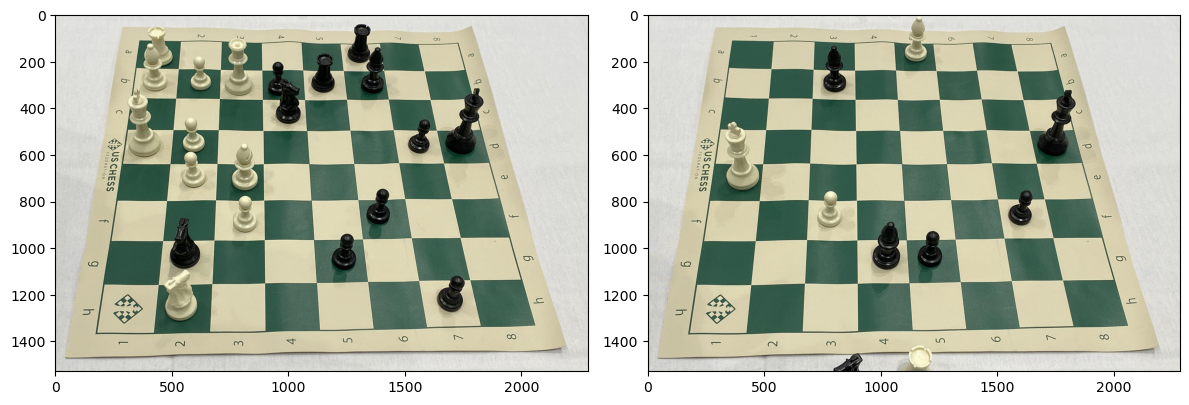

In [5]:
untrained_model = FasterRCNN()
test_dataset = CPDDataset(TEST_DIR, CLASSES_DICT)
random_indices = np.random.randint(0, high=len(test_dataset), size=2)
images = [test_dataset[i][0] for i in random_indices]
predictions = untrained_model(images)
show_images(images, annotations=predictions, classes_dict=CLASSES_DICT)

### 5. Обучение модели

Для обучения модели использовался фреймворк PyTorch Lightning - https://www.pytorchlightning.ai/

Класс модели реализован в файле model.py. Веса обученной модели можно найти в папке lighnting_logs. Стоит отметить, что датасет довольно маленький - 279 изображений, разбитые на train, validation и test в соотношении 70%:20%:10%. Детектор имеет высоский шанс его запомнить и переобучиться при избыточном количестве эпох. Чтобы избежать этого, проводились эксперименты с различными количествами эпох, и было выбрано значение MAX_EPOCHS = 15, при котором достигается оптимальное качестве модели.

### 6. Измерение качества работы модели

Для измерения качества работы модели использовалась метрики: 

1) Average Precision (для различных порогов IoU: 0.5, 0.75, 0.95)

2) mean Average Precision (mAP@[.5:.95])

3) Accuracy (для оценки точности предсказания класса объекта)

4) Redundancy

Redundancy - метрика автора проекта. Она вычисляется по формуле NUM_PREDICTED_BOXES/NUM_GROUND_TRUTH_BOXES и показывает сколько в среднем предсказанных боксов приходится на один настоящий. Метрика была введена, так как модель генерировала избыточное количество боксов.
Реализацию метрик можно найти в файле metrics.py.

Для отображения графиков изменения значений метрик и лосса в процессе обучения используется TensorBoard. Вся информация доступна по ссылке https://tensorboard.dev/experiment/Cje3f6dORye2b4X9vmYjFw/#scalars

Ниже представлены визуальные примеры детекции на тестовом датасете.

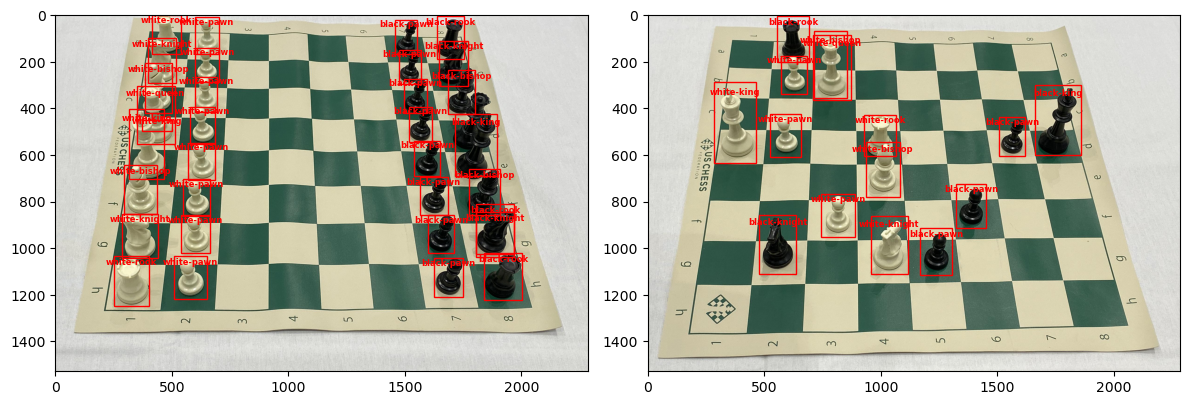

In [18]:
model = FasterRCNN.load_from_checkpoint('lightning_logs/version_0/checkpoints/epoch=14-step=765.ckpt')
test_dataset = CPDDataset(TEST_DIR, CLASSES_DICT)
random_indices = np.random.randint(0, high=len(test_dataset), size=2)
images = [test_dataset[i][0] for i in random_indices]
predictions = model(images)
show_images(images, annotations=predictions, classes_dict=CLASSES_DICT)

In [13]:
df_classes, df_all = evaluate_model(model, test_dataset)

Значения метрик качества на тестовом датасете усредненно по всем классам.

In [14]:
display(df_all)

,AP50,AP75,AP95,mAP,accuracy,redundancy
0,0.972441,0.952756,0.023622,0.76378,0.885305,1.098425


Значения метрик качества на тестовом датасете в разрезе класса.

In [15]:
display(df_classes)

,class,AP50,AP75,AP95,mAP,accuracy,redundancy
0,black-queen,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,black-knight,0.941176,0.941176,0.000000,0.705882,0.772727,1.294118
2,white-queen,0.900000,0.800000,0.000000,0.660000,0.714286,1.400000
3,white-bishop,0.933333,0.933333,0.000000,0.740000,0.750000,1.333333
4,white-king,0.916667,0.916667,0.083333,0.750000,0.857143,1.166667
5,black-king,0.916667,0.916667,0.000000,0.700000,1.000000,1.000000
6,white-knight,0.944444,0.944444,0.000000,0.744444,0.782609,1.277778
7,black-bishop,0.933333,0.933333,0.000000,0.686667,1.000000,1.000000
8,white-rook,0.928571,0.928571,0.000000,0.742857,0.823529,1.214286
9,black-rook,0.944444,0.888889,0.000000,0.750000,0.850000,1.111111


### 7. Возможные пути применения модели.

При незначительных доработках и обучении на датасете бОльшего размера модель сможет с высокой точностью определять положение и классы фигур на доске. Основной путь применения модели - использование ее для преобразовния данных из формата изображение/видео (при доработке) к текстовому формату, например xml, в котором их можно будет свободно хранить и использовать. Это может быть полезно для организаций, проводящих шахматные турниры, для автоматизации сбора данных о партиях и улучшении их качества. 

Данные о сыгранных партиях и данные об игре в прямом эфире - ценнейший ресурс в шахматном мире, применений которому множество: разбор партий, распознавание некорректных ходов в процессе игры, анализ игровой позиции в прямом эфире, использование данных для обучения игровых нейросетей и многое другое.